# Real Data Example: PBMC Dataset

Applying InverseSC to real single-cell data and comparing with standard approaches.

In [1]:
import numpy as np
import scanpy as sc
import inverse_sc as isc
import matplotlib.pyplot as plt

/home/edwardb/miniforge3/envs/universal/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


## 1. Load Data

Using the classic PBMC3k dataset from 10x Genomics.

In [2]:
# Load PBMC dataset
adata = sc.datasets.pbmc3k()
print(f"Raw data: {adata.shape}")

Raw data: (2700, 32738)


## 2. Basic Quality Control

In [3]:
# Standard QC
isc.pp.basic_qc(adata, min_genes=200, max_pct_mito=5)
print(f"After QC: {adata.shape}")

After QC: (2700, 32738)


## 3. Standard Pipeline (Baseline)

In [4]:
# Save raw counts
adata.layers['counts'] = adata.X.copy()

# Standard Scanpy preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# PCA and clustering
sc.tl.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added='leiden_standard')
sc.tl.umap(adata)

# Save standard UMAP
adata.obsm['X_umap_standard'] = adata.obsm['X_umap'].copy()

/home/edwardb/miniforge3/envs/universal/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
2026-01-09 05:50:51.958909: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-09 05:50:51.968303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-09 05:50:51.980856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempti

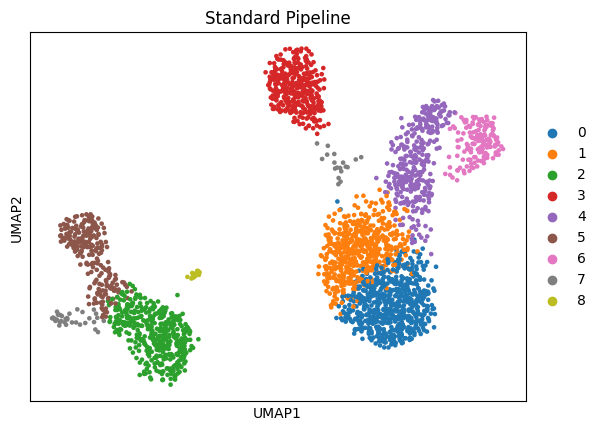

In [5]:
# Visualize standard pipeline
sc.pl.umap(adata, color='leiden_standard', title='Standard Pipeline')

## 4. Inverse Problem Approach

In [ ]:
# Fit inverse model on raw counts
isc.pp.fit_inverse_model(
    adata,
    layer='counts',
    n_latent=50,
    n_programs=15,
    n_epochs=200,
    batch_size=256,
)

/mnt/cce9630f-8b3b-4312-932d-ff04311ba514/SSD/Inverse-Problem-Framing-scRNAseq/inverse_sc/measurement/capture.py:187: RuntimeWarning: divide by zero encountered in log
  capture_logit = np.log(capture_rate_estimate / (1 - capture_rate_estimate + 1e-8))
Training: 100%|█████████████████| 200/200 [09:14<00:00,  2.77s/it, ELBO=-8.06e+5]


In [ ]:
# Clustering on inferred expression
sc.pp.neighbors(adata, use_rep='Z_true_mean')
sc.tl.leiden(adata, key_added='leiden_inverse')
sc.tl.umap(adata)

# Save inverse UMAP
adata.obsm['X_umap_inverse'] = adata.obsm['X_umap'].copy()

## 5. Compare Results

In [ ]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard
sc.pl.umap(adata, color='leiden_standard', ax=axes[0], show=False, title='Standard Pipeline')

# Inverse
sc.pl.umap(adata, color='leiden_inverse', ax=axes[1], show=False, title='Inverse Problem')

plt.tight_layout()
plt.show()

## 6. Uncertainty Analysis

In [ ]:
# Compute cluster confidence
isc.tl.cluster_uncertainty(adata, cluster_key='leiden_inverse')

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.umap(adata, color='leiden_inverse', ax=axes[0], show=False)
sc.pl.umap(adata, color='cluster_confidence', cmap='RdYlGn', ax=axes[1], show=False)
sc.pl.umap(adata, color='cluster_distance', cmap='viridis', ax=axes[2], show=False)

plt.tight_layout()
plt.show()

In [ ]:
# Identify uncertain cells
uncertain_cells = adata.obs['cluster_confidence'] < 0.5
print(f"Uncertain cells: {uncertain_cells.sum()} / {adata.n_obs} ({uncertain_cells.sum()/adata.n_obs:.1%})")

# Which clusters have most uncertainty?
uncertainty_by_cluster = adata.obs.groupby('leiden_inverse')['cluster_confidence'].mean().sort_values()
print("\nMean confidence by cluster:")
print(uncertainty_by_cluster)

## 7. Differential Expression with Uncertainty

In [ ]:
# Pick two clusters to compare
de_results = isc.tl.differential_expression_robust(
    adata,
    group_key='leiden_inverse',
    group1='0',
    group2='1',
)

# Show top confident DE genes
confident_de = de_results[de_results['confident']]
confident_de = confident_de.sort_values('log_fold_change', ascending=False)

print(f"\nConfident DE genes: {len(confident_de)}")
print("\nTop upregulated in group 0:")
print(confident_de.head(10)[['gene_names', 'log_fold_change', 'p_adj']])

print("\nTop upregulated in group 1:")
print(confident_de.tail(10)[['gene_names', 'log_fold_change', 'p_adj']])

## 8. Program Interpretation

In [ ]:
# Interpret learned programs
program_info = isc.tl.interpret_programs(adata, top_genes=30)

# Show top genes for first 3 programs
for prog_idx in range(min(3, len(program_info))):
    print(f"\n=== Program {prog_idx} ===")
    print(program_info[prog_idx].head(15))

In [ ]:
# Visualize program activity on UMAP
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for prog_idx in range(min(6, adata.obsm['program_weights'].shape[1])):
    sc.pl.umap(
        adata,
        color=adata.obsm['program_weights'][:, prog_idx],
        cmap='viridis',
        ax=axes[prog_idx],
        show=False,
        title=f'Program {prog_idx}',
    )

plt.tight_layout()
plt.show()

## 9. Comparison with Known Markers

In [ ]:
# Known PBMC markers
marker_genes = {
    'CD4_T': ['IL7R', 'CD4'],
    'CD8_T': ['CD8A', 'CD8B'],
    'B_cells': ['CD79A', 'MS4A1'],
    'Monocytes': ['CD14', 'LYZ'],
    'NK': ['NKG7', 'GNLY'],
}

# Check if markers are in data
available_markers = {}
for cell_type, genes in marker_genes.items():
    available = [g for g in genes if g in adata.var_names]
    if available:
        available_markers[cell_type] = available

print("Available markers:")
for ct, genes in available_markers.items():
    print(f"  {ct}: {genes}")

## 10. Summary

In [ ]:
print("=== ANALYSIS SUMMARY ===")
print(f"\nCells: {adata.n_obs}")
print(f"Genes: {adata.n_vars}")
print(f"\nClusters (standard): {adata.obs['leiden_standard'].nunique()}")
print(f"Clusters (inverse): {adata.obs['leiden_inverse'].nunique()}")
print(f"\nMean cluster confidence: {adata.obs['cluster_confidence'].mean():.3f}")
print(f"Uncertain cells: {(adata.obs['cluster_confidence'] < 0.5).sum()} ({(adata.obs['cluster_confidence'] < 0.5).sum()/adata.n_obs:.1%})")
print("\n✓ Analysis complete!")